In [177]:
import csv
import random
import os
from IPython.display import clear_output
from sklearn.preprocessing import RobustScaler, MinMaxScaler, normalize
import librosa
import matplotlib.pyplot as plt
import numpy as np

filename = './BMD-HS-Dataset/train.csv'

In [178]:
with open(filename) as f:
    reader = csv.reader(f)
    chosen_row = random.choice(list(reader))

print(chosen_row[6])

MD_070_sup_Mit


In [179]:
filename = os.path.join('.', 'BMD-HS-Dataset', 'train', chosen_row[6] + '.wav')

теперь попробуем удалить один канал и прослушать его

In [180]:
req_len = 20
data, rate = librosa.load(filename, sr=None, mono=True)
req_samples = req_len * rate
if(rate*len(data) > req_len):
  data = data[(len(data) - req_samples) // 2:req_samples + (len(data) - req_samples) // 2]
elif (rate*len(data) < req_len):
  data = np.pad(data, ((req_samples - len(data)) // 2))

print(data)
print(len(data)/rate, rate, len(data))

[0.         0.         0.         ... 0.32702637 0.33776855 0.34631348]
20.0 4000 80000


In [181]:
t = np.arange (0, len(data)/rate, 1/rate)
print(t, len(t)/rate)

[0.000000e+00 2.500000e-04 5.000000e-04 ... 1.999925e+01 1.999950e+01
 1.999975e+01] 20.0


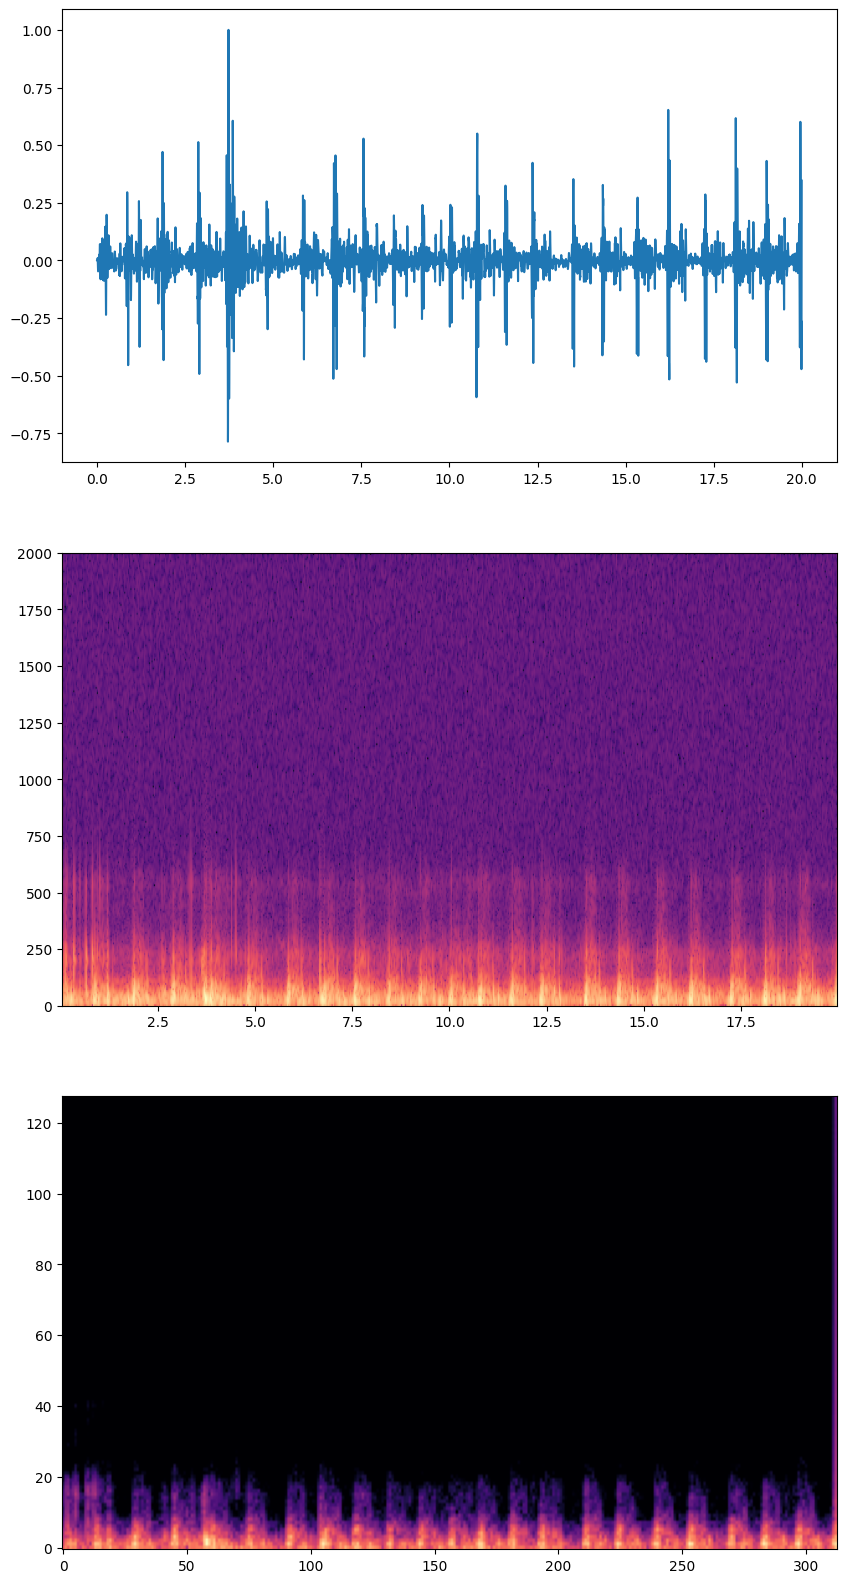

In [182]:
fig, (ax0, ax4, ax5) = plt.subplots(nrows=3, sharex=False)

ax0.plot(t, data)

ax4.specgram(data, Fs=rate, scale='dB', pad_to=512, mode='psd', scale_by_freq=True, detrend='mean', cmap='magma')

Pxx = librosa.stft(data, dtype=np.float32, n_fft=1024)
Pxx, _ = librosa.magphase(Pxx)
Pxx = librosa.feature.melspectrogram(S=Pxx, sr=rate, n_fft=1024)
Pxx = librosa.amplitude_to_db(Pxx, ref=np.min)
im1 = ax5.imshow(Pxx, origin='lower', cmap='magma', aspect='auto')

ax5.axis()
fig.set_figwidth(10)
fig.set_figheight(20)
plt.show()

In [183]:
Pxx = Pxx[:60]
print(Pxx.max())
print(Pxx.shape)

123.53021
(60, 313)


In [184]:
%matplotlib inline 
#pip install jupyter ipympl - for this

def live_plot(data, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    plt.plot(data)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left') # the plot evolves to the right
    plt.show();

# arr = []
# for i in range (100):
#   arr.append(i**2)
#   live_plot(arr)


(60, 313)


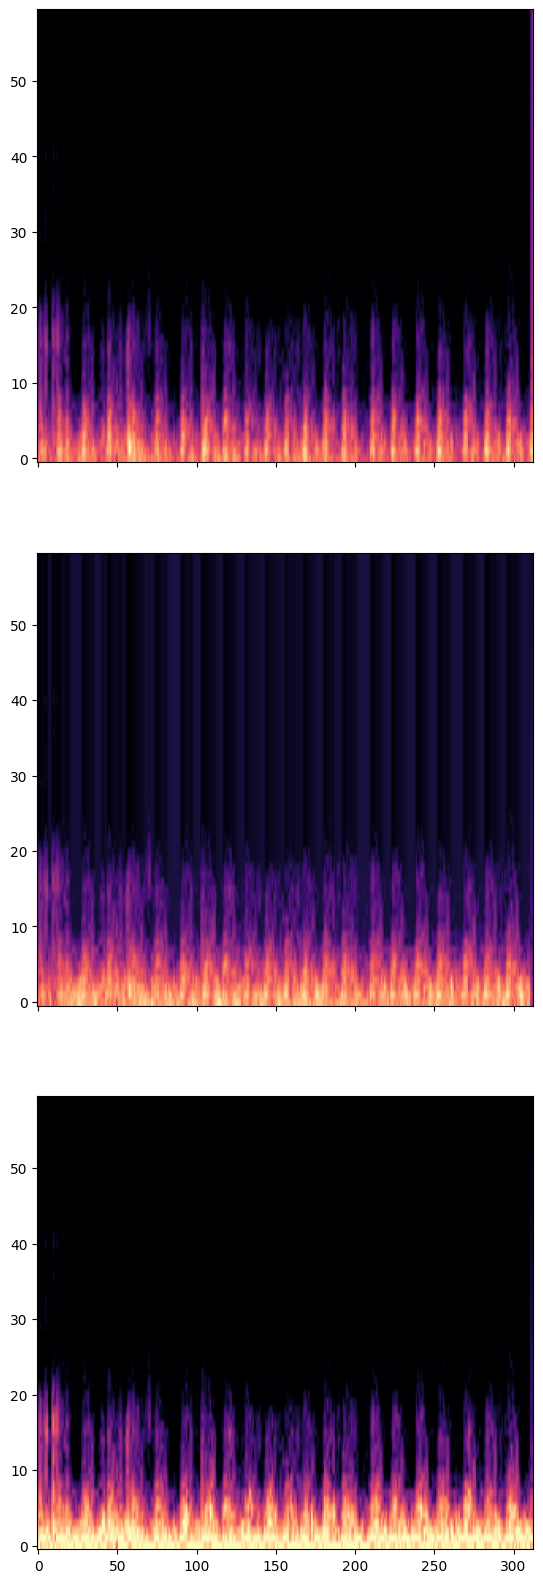

In [185]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True)

scalerR = RobustScaler()

# Pxx, freqs, bins, im = ax0.specgram(data_filtered, Fs=rate, scale='dB', pad_to=255, mode='psd', scale_by_freq=True, detrend='mean')
map1 = ax0.imshow(Pxx, origin='lower', aspect='auto', cmap='magma')

Pxx2 = normalize(Pxx, axis=0, norm='l1')
map2 = ax1.imshow(Pxx2, origin='lower', aspect='auto', cmap='magma')

scaler = MinMaxScaler()

Pxx3 = scaler.fit_transform(Pxx)
map3 = ax2.imshow(Pxx3, origin='lower', aspect='auto', cmap='magma')

# fig.set_figwidth(80)
# fig.set_figheight(20)
# ax0.axis(ymin=0, ymax=1)
# ax1.axis(ymin=0, ymax=1)
# fig.set_figwidth(40)
fig.set_figheight(20)
print(Pxx.shape)

plt.show()

In [186]:
Pxx = np.array(Pxx)
print(Pxx3, len(Pxx3)) # элемент массива - амплитуды частот
print(Pxx.shape)

[[1.0000000e+00 9.9999994e-01 8.5123599e-01 ... 1.0000000e+00
  8.3514178e-01 8.8537514e-01]
 [9.0369368e-01 9.5439965e-01 1.0000000e+00 ... 9.7420418e-01
  1.0000001e+00 9.9999988e-01]
 [8.4710932e-01 8.9014608e-01 9.1368473e-01 ... 9.5814359e-01
  9.1618621e-01 8.0321658e-01]
 ...
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  8.1549883e-03 6.6399574e-05]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  5.5860281e-03 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 5.3315163e-03]] 60
(60, 313)


In [187]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

Теперь нужно создавать такую спектрограмму для любого файла и паковать ее в трехмерный массив:

In [188]:

class SinglePatientData:
  def __init__(self, names : list, flags : list):
    self.contents = {
              'sup_mit_file_name' : '', 
              'sup_tri_file_name' : '' , 
              'sup_pul_file_name' : '' , 
              'sup_aor_file_name' : '' ,
              'sit_mit_file_name' : '' , 
              'sit_tri_file_name' : '' , 
              'sit_pul_file_name' : '' , 
              'sit_aor_file_name' : '' ,}
  
    self.diagnosis_flags = {'AorticStenosis' : 0, 
                      'AorticRegurgitation' : 0,
                      'Mitral Regirgitation' : 0,
                      'Mitral Stenosis' : 0,
                      'Normal' : 0}
    i = 0
    for key in self.contents:
      try: #todo
        self.contents[key] = names[i];
      except:
        self.contents[key] = ''
      finally:
        i += 1
    i = 0
    for key in self.diagnosis_flags:
      try:
        self.diagnosis_flags[key] = int(flags[i]);
      except:
        self.diagnosis_flags[key] = 0
      finally:
        i += 1
  def getTensor(self, path): # returns 129x1249x5 torch tensor
    if (hasattr(self, 'specgrams')):
      return self.specgrams
    else:
      returned_tensor = []
      for name in list(self.contents.values()):
        scaler = MinMaxScaler()
        req_len = 20
        data, rate = librosa.load(os.path.join(path, name + '.wav'), sr=None, mono=True)
        req_samples = req_len * rate
        if(len(data) > req_len * rate):
          data = data[(len(data) - req_samples) // 2:req_samples + (len(data) - req_samples) // 2]
        elif (len(data) < req_len * rate):
          data = np.pad(data, ((req_samples - len(data)) // 2))
        
        Pxx = librosa.stft(data, dtype=np.float32, n_fft=1024)
        Pxx, _ = librosa.magphase(Pxx)
        Pxx = librosa.feature.melspectrogram(S=Pxx, sr=rate, n_fft=1024)
        Pxx = librosa.amplitude_to_db(Pxx, ref=np.min)

        Pxx = scaler.fit_transform(Pxx[:60])
        returned_tensor.append(Pxx)
      returned_tensor = np.array(returned_tensor, dtype=np.float32)

      self.specgrams = torch.from_numpy(returned_tensor)
      return self.specgrams
    

In [189]:
def createDataArray(csvFilename):
  with open(csvFilename) as file:
    retArray = []
    reader = csv.reader(file, delimiter=',')
    reader.__next__() 
    for row in reader:
      retArray.append(SinglePatientData(list(row[6 : ]), list(row[1: 6])))
    return retArray

In [190]:
foldername = os.path.join('.', 'BMD-HS-Dataset')
trainFoldername = os.path.join(foldername, 'train')
trainCsvName = os.path.join(foldername, 'train.csv')

In [191]:
dataArray = createDataArray(trainCsvName)

print(random.choice(dataArray).contents)
print(random.choice(dataArray).diagnosis_flags)

{'sup_mit_file_name': 'MD_077_sup_Mit', 'sup_tri_file_name': 'MD_077_sup_Tri', 'sup_pul_file_name': 'MD_077_sup_Pul', 'sup_aor_file_name': 'MD_077_sup_Aor', 'sit_mit_file_name': 'MD_077_sit_Mit', 'sit_tri_file_name': 'MD_077_sit_Tri', 'sit_pul_file_name': 'MD_077_sit_Pul', 'sit_aor_file_name': 'MD_077_sit_Aor'}
{'AorticStenosis': 0, 'AorticRegurgitation': 0, 'Mitral Regirgitation': 0, 'Mitral Stenosis': 0, 'Normal': 1}


{'AorticStenosis': 0, 'AorticRegurgitation': 1, 'Mitral Regirgitation': 1, 'Mitral Stenosis': 0, 'Normal': 0}
torch.Size([8, 60, 313])


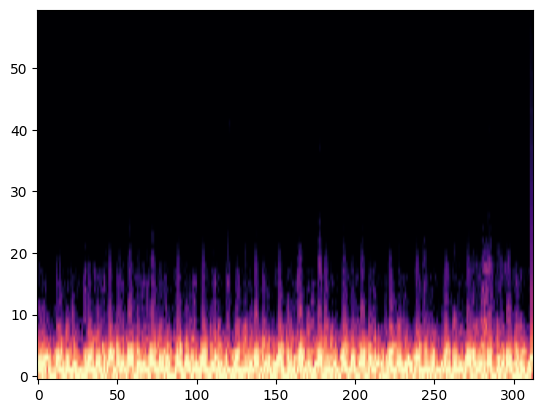

In [192]:
import warnings 
warnings.filterwarnings('ignore')

dataIterator = iter(dataArray)

fig, ax0 = plt.subplots()
rnd = random.choice(dataArray)
map3 = ax0.imshow(rnd.getTensor(trainFoldername)[0], origin='lower', aspect='auto', cmap='magma')
print(random.choice(dataArray).diagnosis_flags)
print(rnd.getTensor(trainFoldername).shape)

plt.show()

Теперь можно приступать к созданию первой модели

In [193]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu124
False


In [194]:
class ConvModel(nn.Module):
    def __init__(self):
        super(ConvModel, self).__init__()
        conv_layers = []
        lin_layers = []

        self.conv1 = nn.Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.3)
        torch.nn.init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.dropout1]

        self.conv2 = nn.Conv2d(
            16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2)
        )
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.3)
        torch.nn.init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.dropout2]

        self.conv3 = nn.Conv2d(
            32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)
        )
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(p=0.3)
        torch.nn.init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.dropout3]

        self.conv4 = nn.Conv2d(
            64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)
        )
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(p=0.3)
        torch.nn.init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.dropout4]

        self.conv5 = nn.Conv2d(
            128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)
        )
        self.relu5 = nn.ReLU()
        self.dropout5 = nn.Dropout(p=0.3)
        torch.nn.init.kaiming_normal_(self.conv5.weight, a=0.1)
        self.conv5.bias.data.zero_()
        conv_layers += [self.conv5, self.relu5, self.dropout5]

        self.conv6 = nn.Conv2d(
            256, 512, kernel_size=(5, 5), stride=(4, 4), padding=(1, 1)
        )
        self.relu6 = nn.ReLU()
        torch.nn.init.kaiming_normal_(self.conv6.weight, a=0.1)
        self.conv6.bias.data.zero_()
        self.dropout6 = nn.Dropout(p=0.3)
        conv_layers += [self.conv6, self.relu6, self.dropout6]

        self.ap = nn.AdaptiveAvgPool2d(output_size=1)

        self.lin7 = nn.Linear(in_features=512, out_features=256)
        self.relu7 = nn.ReLU()
        self.dropout7 = nn.Dropout(p=0.3)
        lin_layers += [self.lin7, self.relu7, self.dropout7]

        self.lin8 = nn.Linear(in_features=256, out_features=128)
        self.relu8 = nn.ReLU()
        self.dropout8 = nn.Dropout(p=0.3)
        lin_layers += [self.lin8, self.relu8, self.dropout8]

        self.lin9 = nn.Linear(in_features=128, out_features=5)
        # self.relu11 = nn.ReLU()
        lin_layers += [self.lin9, 
                    #    self.relu11
                       ]

        self.lin = nn.Sequential(*lin_layers)
        self.conv = nn.Sequential(*conv_layers)

    def forward(self, x):
        x = self.conv(x)

        x = self.ap(x)
        x = x.view(x.shape[0])

        x = self.lin(x)
        return x

In [195]:
foldername = os.path.join('.', 'BMD-HS-Dataset')
trainFoldername = os.path.join(foldername, 'train')
trainCsvName = os.path.join(foldername, 'train.csv')

dataArray = createDataArray(trainCsvName)
dataIterator = iter(dataArray)

Тестовый прогон:

In [196]:
model = ConvModel()
Pxx = next(dataIterator).getTensor(trainFoldername)
print(Pxx.shape)
out = model(Pxx)
print(out.shape)

torch.Size([8, 60, 313])
torch.Size([5])


In [197]:
learning_rate = 0.001
num_epochs = 50

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ConvModel()
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [198]:
def get_acc(logit, target):
    ''' Check if answer is right for training round '''
    round_logit = torch.round(logit)
    acc = 0
    for i in range(len(target)):
        acc += (1 if int(target[i].item()) <= int(round_logit[i].item()) else 0)
    return acc / len(target)

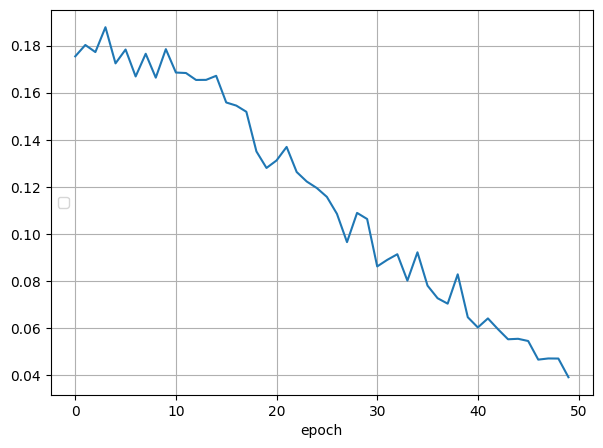

Epoch: 49 | Loss: 0.0391 | Train Accuracy: 1.01


In [201]:
train_acc = 0
epoch = 0
accuracies = []
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    random.shuffle(dataArray)
    dataIterator = iter(dataArray)
    ## training step
    for i, patient in enumerate(dataIterator):
        labels = torch.tensor(list(patient.diagnosis_flags.values()), dtype=torch.float32)

        Pxx = patient.getTensor(trainFoldername);

        ## forward + backprop + loss
        logits = model(Pxx)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_acc(logits, labels)
        print('Loss curr: %.4f, loss mean: %.4f' %(loss.detach().item(), train_running_loss / (i + 1)))

    model.eval()
    accuracies += [train_running_loss / i]
    live_plot(accuracies)
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))

In [203]:
train_running_loss, train_acc = 0., 0.
random.shuffle(dataArray)
dataIterator = iter(dataArray)
for i, patient in enumerate(dataIterator):
        labels = torch.tensor(list(patient.diagnosis_flags.values()), dtype=float)

        Pxx = patient.getTensor(trainFoldername);

        ## forward + backprop + loss
        logits = model(Pxx)
        loss = criterion(logits, labels)

        train_running_loss += loss.detach().item()
        train_acc += get_acc(logits, labels)
        print('target: %s, logits: %s, loss: %f, acc: %f, acc_abs: %f' %(labels.detach().numpy(), logits.round().detach().numpy(), train_running_loss / (i + 1), train_acc / (i + 1), get_acc(logits, labels)))


target: [0. 1. 0. 1. 0.], logits: [ 0.  1.  0.  1. -0.], loss: 0.016894, acc: 1.000000, acc_abs: 1.000000
target: [0. 0. 0. 1. 0.], logits: [ 0.  0.  0.  1. -0.], loss: 0.009887, acc: 1.000000, acc_abs: 1.000000
target: [0. 0. 1. 0. 0.], logits: [0. 0. 1. 0. 0.], loss: 0.009877, acc: 1.000000, acc_abs: 1.000000
target: [1. 0. 1. 0. 0.], logits: [ 1.  0.  1. -0. -0.], loss: 0.013966, acc: 1.000000, acc_abs: 1.000000
target: [1. 1. 0. 1. 0.], logits: [1. 1. 0. 1. 0.], loss: 0.015428, acc: 1.000000, acc_abs: 1.000000
target: [0. 0. 0. 0. 1.], logits: [0. 0. 0. 0. 1.], loss: 0.013090, acc: 1.000000, acc_abs: 1.000000
target: [1. 0. 0. 0. 0.], logits: [ 1. -0. -0.  0. -0.], loss: 0.012055, acc: 1.000000, acc_abs: 1.000000
target: [0. 1. 0. 1. 0.], logits: [ 0.  1.  0.  1. -0.], loss: 0.013303, acc: 1.000000, acc_abs: 1.000000
target: [1. 1. 0. 0. 0.], logits: [1. 1. 0. 0. 0.], loss: 0.014008, acc: 1.000000, acc_abs: 1.000000
target: [0. 0. 0. 0. 1.], logits: [0. 0. 0. 0. 1.], loss: 0.012826

In [204]:
torch.save(model.state_dict(), os.path.join('.', 'models', 'cnn', 'model.pt'))